# Simulate the Tree
This notebook simulates a phylogenetic tree under the dual-birth model [(Moshiri & Mirarab, 2017)](https://doi.org/10.1093/sysbio/syx088) and performs some basic analyses of the tree.

---
**Rule 2: Document Process, Not Just Results.** Here we describe the steps how to produce the dataset.

**Rule 3: Build a Pipeline.** This notebook describes the entire workflow, and its modularity makes it easy to change models or model parameters.

**Rule 7: Share and Explain Your Data.** To enable reproducibility we provide a `/intermediate_data` directory with files produced by the workflow.

---

## Define Tree Simulation Parameters
In the dual-birth model, all branches are labeled as either *active* or *inactive* and is parameterized by two rates: the *birth rate* $\left(\lambda_b\right)$, which is the Poisson rate at which active branches split, and the *activation rate* $\left(\lambda_a\right)$, which is the Poisson rate at which inactive branches split, where $\lambda_a\le\lambda_b$. We will start by choosing our desired values for these two rates. For our purposes, we will choose the rate estimates for *Alu* elements as found in the original manuscript [(Moshiri & Mirarab, 2017)](https://doi.org/10.1093/sysbio/syx088).

Our tree simulations also require an end criterion: either a tree height or a number of leaves. We will specify that we want trees with *n* = 100 leaves.

We will also include import statements here to keep the notebook clean and organized.

In [1]:
OUTPUT_TREE_FILE = "./intermediate_data/dualbirth.tre"
BIRTH_RATE = 122.03
ACTIVATION_RATE = 0.73
NUM_LEAVES = 100

In [2]:
import matplotlib.pyplot as plt
from seaborn import distplot
from treesap import dualbirth_tree

## Simulate the Tree
We can now use [TreeSAP](https://github.com/niemasd/TreeSAP) to simulate the tree, which will return a [TreeSwift](https://github.com/niemasd/TreeSwift) `Tree` object.

In [3]:
tree = dualbirth_tree(Lb=BIRTH_RATE, La=ACTIVATION_RATE, end_num_leaves=NUM_LEAVES)

A common file format to represent tree structures is the Newick format. In TreeSwift, `Tree` objects have a `newick()` function to output a Newick string representation of the tree. The `str()` cast automatically calls the `newick()` function, so we can use Python's `print()` function to print the tree in the Newick format conveniently. Thus, we could run `print(tree)` to print a Newick string representation of the tree we have simulated under the dual-birth model, but because of the length, we will only print a prefix to give you an idea of how it looks.

In [4]:
print('%s...' % tree.newick()[:100])

[&R] ((((((((((((((((((((((((((((((((((((((99:0.029959523341435368,98:0.029959523341435368):0.004016...


## Explore the Tree
Now that we've simulated our tree, we can begin to explore its properties and statistics. For example, consider the following questions:
* How many lineages exist at any given "time" (where "time" is measured in unit of "expected number of per-site mutations")?
* What is the branch length distribution? What about just internal branches? What about just terminal branches?
* What is the height? Diameter?
* What is the average branch length? Internal branch length? Terminal branch length?
* What is the Colless balance index? Sackin balance index? Gamma statistic? Treeness?

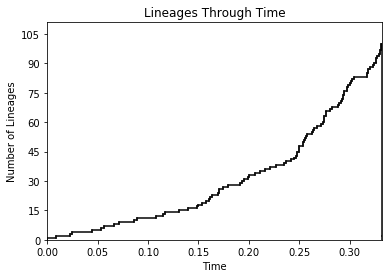

In [5]:
tree.ltt(); plt.show()

We see that, as we move forward in time, the number of lineages grows more and more rapidly. This is because, in the dual-birth model, each lineage is a Poisson process, so the rate at which splitting events occurs increases as more lineages are created.

In [6]:
branch_lengths = dict()
branch_lengths['all'] = list(tree.branch_lengths())
branch_lengths['internal'] = list(tree.branch_lengths(terminal=False))
branch_lengths['terminal'] = list(tree.branch_lengths(internal=False))

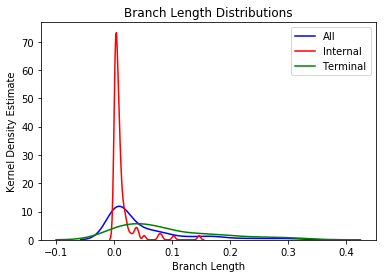

In [7]:
colors = {'all':'blue', 'internal':'red', 'terminal':'green'}
for k in sorted(branch_lengths.keys()):
    distplot(branch_lengths[k], kde=True, hist=False, color=colors[k], label=k.capitalize());
plt.title("Branch Length Distributions");
plt.xlabel("Branch Length");
plt.ylabel("Kernel Density Estimate");

We see that, as expected under the dual-birth model, the distribution of internal branch lengths is smaller than that of terminal branch lengths. Specifically, we see that the vast majority of internal branches are very close to 0 length (i.e., are extremely short).

We can compare these three branch length distributions numerically as well by comparing their averages.

In [8]:
print("Average Branch Length: %f" % tree.avg_branch_length())
print("Average Internal Branch Length: %f" % tree.avg_branch_length(terminal=False))
print("Average Terminal Branch Length: %f" % tree.avg_branch_length(internal=False))

Average Branch Length: 0.051734
Average Internal Branch Length: 0.012239
Average Terminal Branch Length: 0.090834


In addition to looking at the branch length distributions of trees, it is common to look at the *height* (i.e., maximum distance from the root to a leaf), *diameter* (i.e., maximum pairwise distance between leaves), and *treeness* (sum of internal branch lengths divided by sum of all branch lengths). These values give you an idea of the distances between elements in your tree.

In [9]:
print("Height: %f" % tree.height())
print("Diameter: %f" % tree.diameter())
print("Treeness: %f" % tree.treeness())

Height: 0.332198
Diameter: 0.647105
Treeness: 0.117697


In addition to distances on a phylogenetic tree, the topology of the tree is typically of importance to us. In the case of the dual-birth model, the topology of the tree is significantly affected by the ratio $r={\lambda_a}/{\lambda_b}$, and the balance of the tree can be used to estimate this ratio. Two common metrics to do so are the Colless Balance Index and the Sackin Index, both of which are described by [Mir, Rossello, & Rotger (2012)](https://arxiv.org/abs/1202.1223).

In [10]:
print("Colless Balance Index: %f" % tree.colless())
print("Sackin Balance Index: %f" % tree.sackin())

Colless Balance Index: 0.380746
Sackin Balance Index: 21.810000


The rates of speciation down the tree are also inherently of interest. Given a phylogenetic tree, we may want to test the null hypothesis that speciation occurs at a constant rate over time. [Pybus & Harvey (2000)](https://doi.org/10.1098/rspb.2000.1278) developed a statistical test, the $\gamma$-statistic, to compare a given tree against the null hypothesis. The $\gamma$-statistic is essentially a summary of the information contained in the internode intervals of a phylogeny. If $\gamma>0$, a phylogeny's internal nodes are closer to the leaves than expected under with a constant rate of speciation, and if $\gamma<0$, the internal nodes are closer to the root than expected. In this example, we saw earlier that the tree we simulated under the dual-birth model had much longer terminal branches than internal branches, which implies that we would expect a very negative $\gamma$.

In [11]:
print("Gamma Statistic: %f" % tree.gamma_statistic())

Gamma Statistic: -7.075471


## Save Dataset
Now that we have finished exploring our tree, we can save it in the Newick format. The tool that we wish to use next doesn't support the "rooted" prefix of the Newick format (`[&R]`), so we need to specify to TreeSwift that we wish to omit the "rooted" prefix.

In [12]:
tree.write_tree_newick(OUTPUT_TREE_FILE, hide_rooted_prefix=True)

## Next step
After you saved the dataset here, go back to the [0-Workflow.ipynb](./0-Workflow.ipynb) or go to [2-SimulateSequences.ipynb](./2-SimulateSequences.ipynb) to run the next step of the analysis.

---

**Author:** [Niema Moshiri](https://niema.net/), UC San Diego, October 2, 2018

---